# Modèle de Prédiction des Hospitalisations avec PyCaret

In [1]:
import numpy as np
from pycaret.regression import *
from sklearn.model_selection import train_test_split
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from google.cloud import bigquery
import os

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/antob/Documents/Arctusol/projet_wagon/projet_data_JBN/projet-jbn-data-le-wagon-533639ce801d.json"
        # Initialisation du client BigQuery
client = bigquery.Client()

query = """
SELECT * FROM projet-jbn-data-le-wagon.dbt_medical_analysis_join_total_morbidite.class_join_total_morbidite_sexe_population

"""

df_hospi = client.query(query).to_dataframe()


In [38]:
df_hospi_dpt_ens = df_hospi[(df_hospi["niveau"] == "Départements") & (df_hospi["sexe"] == "Ensemble")]
df_hospi_dpt_HF = df_hospi[(df_hospi["niveau"] == "Départements") & (df_hospi["sexe"] != "Ensemble")]
df_hospi_reg_ens = df_hospi[(df_hospi["niveau"] == "Régions") & (df_hospi["sexe"] == "Ensemble")]
df_hospi_reg_HF = df_hospi[(df_hospi["niveau"] == "Régions") & (df_hospi["sexe"] != "Ensemble")]

In [39]:
df_hospi_dpt_ens_yr = df_hospi_dpt_ens[df_hospi_dpt_ens["annee"].isin([2018, 2019, 2020,2021, 2022])]
df_hospi_dpt_HF_yr =df_hospi_dpt_HF[df_hospi_dpt_HF["annee"].isin([2018, 2019,2020,2021, 2022])]
df_hospi_reg_ens_yr = df_hospi_reg_ens[df_hospi_reg_ens["annee"].isin([2018, 2019,2020,2021, 2022])]
df_hospi_reg_HF_yr =df_hospi_reg_HF[df_hospi_reg_HF["annee"].isin([2018, 2019, 2022])]

In [ ]:
"""'hospi_prog_24h', 'hospi_autres_24h', 'hospi_total_24h',
    'hospi_1J', 'hospi_2J', 'hospi_3J', 'hospi_4J', 'hospi_5J',
    'hospi_6J', 'hospi_7J', 'hospi_8J', 'hospi_9J',
    'hospi_10J_19J', 'hospi_20J_29J', 'hospi_30J',
        'tranche_age_0_1', 'tranche_age_1_4', 'tranche_age_5_14',
    'tranche_age_15_24', 'tranche_age_25_34', 'tranche_age_35_44',
    'tranche_age_45_54', 'tranche_age_55_64', 'tranche_age_65_74',
    'tranche_age_75_84', 'tranche_age_85_et_plus'"""

In [40]:
# Préparation des données d'entraînement (2018-2019)
train_data_ens = df_hospi_reg_ens_yr[df_hospi_reg_ens_yr['annee'].isin([2018, 2019, 2020, 2021])]
test_data_ens = df_hospi_reg_ens_yr[df_hospi_reg_ens_yr['annee'] == 2022]

In [41]:
train_data_hf = df_hospi_reg_HF_yr[df_hospi_reg_HF_yr['annee'].isin([2018, 2019])]
test_data_hf = df_hospi_reg_HF_yr[df_hospi_reg_HF_yr['annee'] == 2022]

In [42]:
# Sélection des variables pertinentes
features = [
    'nom_region', 'nom_pathologie'
]

In [16]:
# Préparation des données pour PyCaret
train_data_ens = train_data_ens[features + ['nbr_hospi']]
test_data_ens = test_data_ens[features + ['nbr_hospi']]
train_data_hf = train_data_hf[features + ['nbr_hospi']]
test_data_hf = test_data_hf[features + ['nbr_hospi']]

In [17]:
train_data_ens

nom_region                        nom_pathologie  \
10974                        Corse    Maladies intestinales infectieuses   
10978                        Corse                           Tuberculose   
10981                        Corse                           Septicémies   
10984                        Corse       Mal.sexuellement transmissibles   
10987                        Corse                     Hépatites virales   
...                            ...                                   ...   
283174  Provence-Alpes-Côte d'Azur                               Dialyse   
283177  Provence-Alpes-Côte d'Azur                         Radiothérapie   
283179  Provence-Alpes-Côte d'Azur            Chimiothérapie pour tumeur   
283182  Provence-Alpes-Côte d'Azur  Surveil.post traitement med.ou chir.   
283185  Provence-Alpes-Côte d'Azur  Recours raison économique ou sociale   

        nbr_hospi  
10974         284  
10978          17  
10981         175  
10984          85  
10987           4  
...           ...  
283174       1677  
283177       2276  
283179      15439  
283182      67273  
283185       2344  

[11412 rows x 3 columns]

In [18]:
s = RegressionExperiment()

In [19]:
# Initialisation de l'environnement PyCaret
s.setup(
    data=train_data_ens,
    target='nbr_hospi',
    session_id=123,
    normalize=True,
    transformation=True,
    fold=10,  # 5-fold cross validation
)

In [20]:
best = s.compare_models()

In [41]:
# Comparaison des modèles
best_model = compare_models(
    exclude=['ransac', 'huber', 'theilsen'],  # On exclut les modèles moins pertinents pour ce cas
    sort='R2',  # Trier par R2 score
    n_select=1  # Sélectionner le meilleur modèle
)

In [21]:
s.get_config("pipeline")

Pipeline(memory=FastMemory(location=C:\Users\antob\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=[], transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['nom_region', 'nom_pathologie'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('onehot_encoding',
                 TransformerWrapper(include=['...
                                    transformer=OneHotEncoder(cols=['nom_region'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('rest_encoding',
                 TransformerWrapper(include=['nom_pathologie'],
                                    transformer=TargetEncoder(cols=['nom_pathologie'],
                                                              handle_missing='return_nan'))),
                ('transformation',
                 TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                ('normalize',
                 TransformerWrapper(transformer=StandardScaler()))])

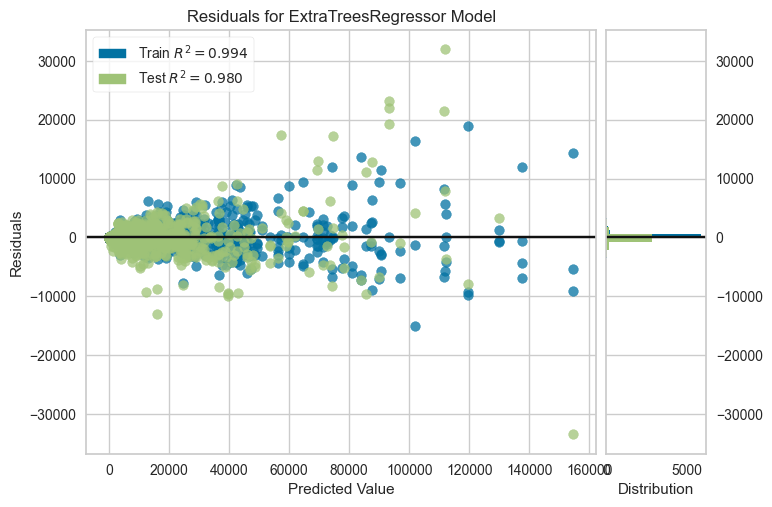

In [22]:
s.plot_model(best)

In [40]:
# Ajout après la comparaison des modèles
from sklearn.model_selection import cross_val_score

# Validation croisée sur le meilleur modèle
cv_scores = cross_val_score(best_model, train_data.drop('nbr_hospi', axis=1), 
                          train_data['nbr_hospi'], 
                          cv=5, 
                          scoring='r2')

print("Scores de validation croisée (R²):")
print(f"Moyenne: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 921, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\generic.py", line 6534, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 414, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 354, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\blocks.py", line 616, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 238, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 183, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 134, in _astype_nansafe
    return arr.astype(dtype, copy=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Anémies'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\sklearn\utils\validation.py", line 921, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\generic.py", line 6534, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 414, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\managers.py", line 354, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\internals\blocks.py", line 616, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 238, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 183, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\antob\Documents\Arctusol\projet_wagon\projet_data_JBN\.venv\Lib\site-packages\pandas\core\dtypes\astype.py", line 134, in _astype_nansafe
    return arr.astype(dtype, copy=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Maladies intestinales infectieuses'


In [24]:
# Tuning du meilleur modèle
tuned_model = tune_model(best)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [26]:
# Analyse du MAE en contexte
print("Statistiques du nombre d'hospitalisations:")
print(train_data['nbr_hospi'].describe())

# Calcul du MAE relatif
mae_relatif = 211 / train_data['nbr_hospi'].mean() * 100
print(f"\nMAE en pourcentage de la moyenne: {mae_relatif:.2f}%")

# Distribution des erreurs
plt.figure(figsize=(10, 6))
erreurs = abs(predictions['nbr_hospi'] - predictions['prediction_label'])
sns.histplot(data=erreurs[erreurs < erreurs.quantile(0.95)], bins=50)
plt.axvline(x=211, color='r', linestyle='--', label='MAE')
plt.title('Distribution des erreurs absolues')
plt.xlabel('Erreur absolue (nombre d\'hospitalisations)')
plt.legend()
plt.show()

Statistiques du nombre d'hospitalisations:


NameError: name 'train_data' is not defined

In [44]:
test_data_sans_nom = test_data_ens.drop(["nbr_hospi"], axis=1)

In [45]:
test_data_ens

niveau                                  cle_unique      sexe  \
124180  Régions                       94 - Corse_01001_2022  Ensemble   
124183  Régions                       94 - Corse_01002_2022  Ensemble   
124188  Régions                       94 - Corse_01003_2022  Ensemble   
124191  Régions                       94 - Corse_01004_2022  Ensemble   
124192  Régions                       94 - Corse_01005_2022  Ensemble   
...         ...                                         ...       ...   
169979  Régions  93 - Provence-Alpes-Côte d'Azur_21155_2022  Ensemble   
169981  Régions  93 - Provence-Alpes-Côte d'Azur_21156_2022  Ensemble   
169985  Régions  93 - Provence-Alpes-Côte d'Azur_21157_2022  Ensemble   
169987  Régions  93 - Provence-Alpes-Côte d'Azur_21158_2022  Ensemble   
169989  Régions  93 - Provence-Alpes-Côte d'Azur_22000_2022  Ensemble   

              year  annee                                  pathologie  \
124180  2022-12-31   2022    01001-Maladies intestinales infectieuses   
124183  2022-12-31   2022                           01002-Tuberculose   
124188  2022-12-31   2022                           01003-Septicémies   
124191  2022-12-31   2022       01004-Mal.sexuellement transmissibles   
124192  2022-12-31   2022                     01005-Hépatites virales   
...            ...    ...                                         ...   
169979  2022-12-31   2022                         21155-Radiothérapie   
169981  2022-12-31   2022            21156-Chimiothérapie pour tumeur   
169985  2022-12-31   2022  21157-Surveil.post traitement med.ou chir.   
169987  2022-12-31   2022  21158-Recours raison économique ou sociale   
169989  2022-12-31   2022               22000-Infection à la Covid-19   

       code_pathologie                        nom_pathologie  \
124180           01001    Maladies intestinales infectieuses   
124183           01002                           Tuberculose   
124188           01003                           Septicémies   
124191           01004       Mal.sexuellement transmissibles   
124192           01005                     Hépatites virales   
...                ...                                   ...   
169979           21155                         Radiothérapie   
169981           21156            Chimiothérapie pour tumeur   
169985           21157  Surveil.post traitement med.ou chir.   
169987           21158  Recours raison économique ou sociale   
169989           22000                  Infection à la Covid   

                                 region code_region  ...  \
124180                       94 - Corse          94  ...   
124183                       94 - Corse          94  ...   
124188                       94 - Corse          94  ...   
124191                       94 - Corse          94  ...   
124192                       94 - Corse          94  ...   
...                                 ...         ...  ...   
169979  93 - Provence-Alpes-Côte d'Azur          93  ...   
169981  93 - Provence-Alpes-Côte d'Azur          93  ...   
169985  93 - Provence-Alpes-Côte d'Azur          93  ...   
169987  93 - Provence-Alpes-Côte d'Azur          93  ...   
169989  93 - Provence-Alpes-Côte d'Azur          93  ...   

       tx_standard_tt_age_pour_mille  indice_comparatif_tt_age_percent  \
124180                          1.34                             78.80   
124183                          0.05                             73.66   
124188                          0.36                            141.92   
124191                          0.24                            137.51   
124192                          0.06                            128.49   
...                              ...                               ...   
169979                          0.40                            140.75   
169981                          2.19                            123.51   
169985                         13.20                            106.95   
169987                   

In [ ]:
# Évaluation sur les données de test (2022)
predictions = s.predict_model(best, data=test_data_sans_nom)
print("Performance sur les données de test (2022):")
print(predictions.head())

In [ ]:
pd.concat(predictions

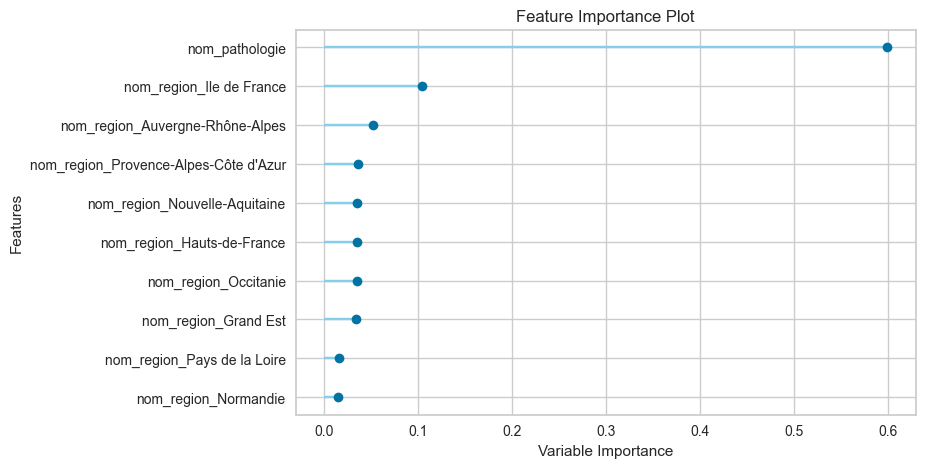

In [50]:
s.plot_model(best, plot = 'feature')

In [47]:
test_data_ens["nbr_hospi"].head()

124180    417
124183     18
124188    168
124191     74
124192     19
Name: nbr_hospi, dtype: Int64

Métriques sur les données de test (2022):
MAE: 239.12
RMSE: 1381.96
R²: 0.9888


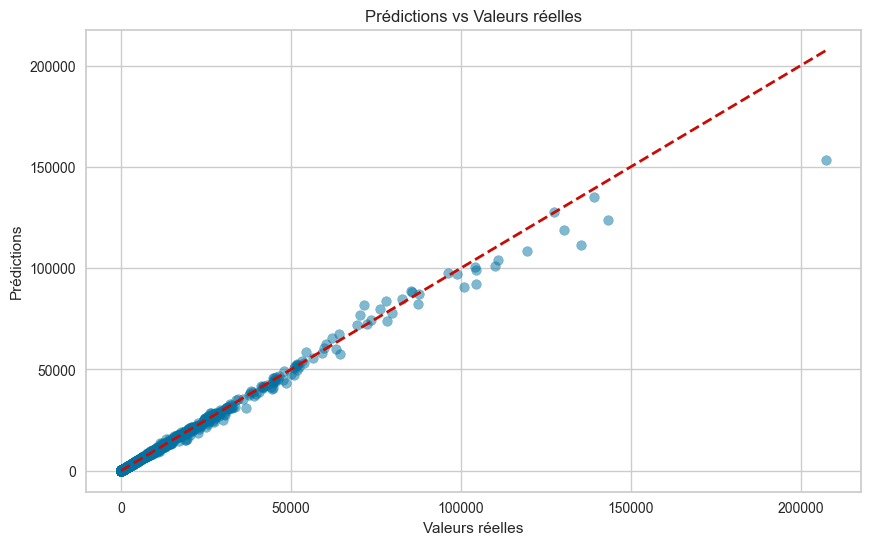


Statistiques des erreurs relatives (%):
count      2862.0
mean          inf
std          <NA>
min           0.0
25%      1.505772
50%      3.386791
75%      6.304061
max           inf
Name: erreur_relative, dtype: Float64


In [14]:
# Calcul des métriques d'erreur pour les prédictions
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extraire les vraies valeurs et les prédictions
y_true = predictions['nbr_hospi']
y_pred = predictions['prediction_label']

# Calcul des métriques
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Métriques sur les données de test (2022):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Visualisation des prédictions vs réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles')
plt.show()

# Calcul et affichage des erreurs relatives
predictions['erreur_relative'] = abs(predictions['nbr_hospi'] - predictions['prediction_label']) / predictions['nbr_hospi'] * 100
print("\nStatistiques des erreurs relatives (%):")
print(predictions['erreur_relative'].describe())